In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Training size: 10000 | Test size: 4000
Clases detectadas: ['Anana', 'Banana', 'Coco', 'Frutilla', 'Higo', 'Manzana', 'Mora', 'Naranja', 'Palta', 'Pera']


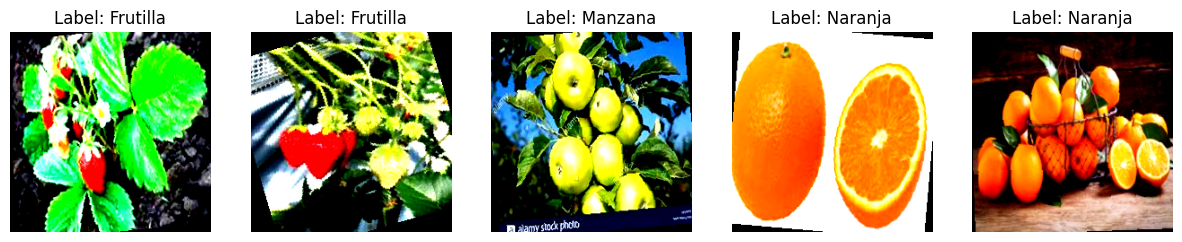


Balance de clases en Training:
  Clase 'Anana': 1000 imágenes
  Clase 'Banana': 1000 imágenes
  Clase 'Coco': 1000 imágenes
  Clase 'Frutilla': 1000 imágenes
  Clase 'Higo': 1000 imágenes
  Clase 'Manzana': 1000 imágenes
  Clase 'Mora': 1000 imágenes
  Clase 'Naranja': 1000 imágenes
  Clase 'Palta': 1000 imágenes
  Clase 'Pera': 1000 imágenes

Balance de clases en Test:
  Clase 'Anana': 400 imágenes
  Clase 'Banana': 400 imágenes
  Clase 'Coco': 400 imágenes
  Clase 'Frutilla': 400 imágenes
  Clase 'Higo': 400 imágenes
  Clase 'Manzana': 400 imágenes
  Clase 'Mora': 400 imágenes
  Clase 'Naranja': 400 imágenes
  Clase 'Palta': 400 imágenes
  Clase 'Pera': 400 imágenes


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


Epoch 1/5 | Train Loss: 0.5678 | Train Acc: 0.8629 | Val Loss: 0.0676 | Val Acc: 0.9845


Epoch 2/5 | Train Loss: 0.1099 | Train Acc: 0.9683 | Val Loss: 0.0320 | Val Acc: 0.9918


Epoch 3/5 | Train Loss: 0.0687 | Train Acc: 0.9801 | Val Loss: 0.0253 | Val Acc: 0.9950


Epoch 4/5 | Train Loss: 0.0518 | Train Acc: 0.9852 | Val Loss: 0.0217 | Val Acc: 0.9945


Epoch 5/5 | Train Loss: 0.0408 | Train Acc: 0.9873 | Val Loss: 0.0211 | Val Acc: 0.9948


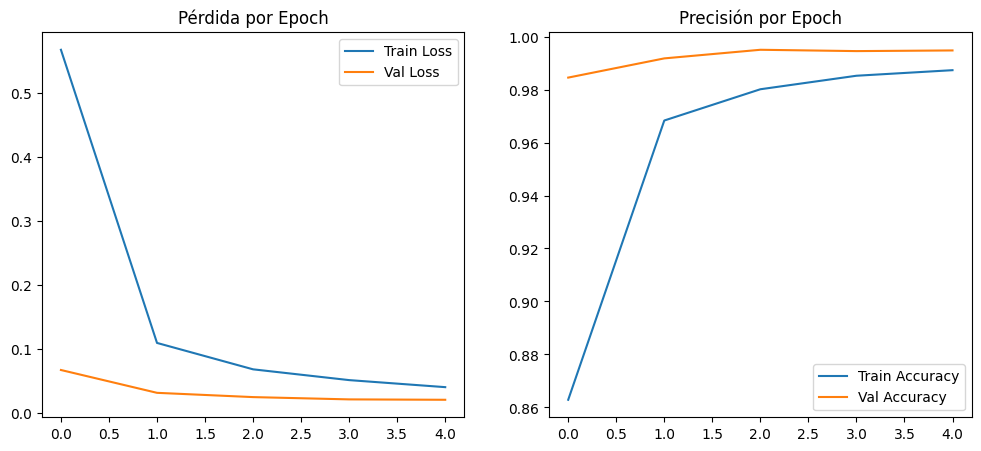

In [1]:
# 1. Imports
import os, random, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# 2. Configuración
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = "/kaggle/input/frutas5/Frutas-seleccionadas"
BATCH_SIZE = 32
EPOCHS = 5

# 3. Visualización
def mostrar_imagenes_aleatorias(dataset, classes):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {classes[label]}")
        axes[i].axis("off")
    plt.show()

# 4. Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 5. Cargar Datos
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "Training"), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "Test"), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training size: {len(train_dataset)} | Test size: {len(val_dataset)}")
print(f"Clases detectadas: {train_dataset.classes}")
mostrar_imagenes_aleatorias(train_dataset, train_dataset.classes)

#  NUEVO: Verificar balanceo de clases
def contar_clases(dataset, nombre_dataset="Dataset"):
    labels = [label for _, label in dataset]
    conteo = Counter(labels)
    print(f"\nBalance de clases en {nombre_dataset}:")
    for idx, cantidad in conteo.items():
        clase = dataset.classes[idx]
        print(f"  Clase '{clase}': {cantidad} imágenes")

contar_clases(train_dataset, "Training")
contar_clases(val_dataset, "Test")

# 6. Modelo EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))
model = model.to(DEVICE)

# 7. Pérdida y Optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 8. Función de Entrenamiento
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            loop.set_postfix(loss=loss.item())

        train_loss /= train_total
        train_acc = train_correct / train_total

        # Validación
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = model(val_images)
                loss = criterion(outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return history

# 9. Entrenar
history = train(model, train_loader, val_loader, criterion, optimizer, DEVICE, epochs=EPOCHS)

# 10. Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Pérdida por Epoch")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Precisión por Epoch")
plt.show()


In [ ]:
#CONCLUSION
#El modelo aprendió muy bien. En cada época, la pérdida (o error) bajó tanto en entrenamiento como en validación,
#y la precisión subió, llegando a más del 99% de aciertos en los datos de validación.

#Esto significa que el modelo no solo memorizó los datos, sino que también generaliza bien con imágenes nuevas.
#Además, la diferencia entre entrenamiento y validación es muy chica, así que no hay sobreajuste.

<Figure size 600x600 with 0 Axes>

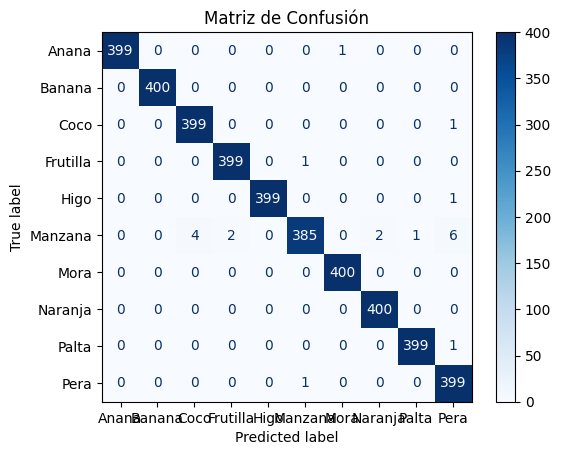

In [2]:
#MATRIZ DE CONFUSION
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def mostrar_matriz_confusion(model, dataloader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Matriz de Confusión")
    plt.show()

# Uso:
mostrar_matriz_confusion(model, val_loader, train_dataset.classes, DEVICE)

In [ ]:
#CONCLUSION
#la fila "Manzana" muestra que de 400 imágenes reales de manzanas, 385 fueron bien clasificadas, y algunas pocas se 
#confundieron con otras frutas como higo, mora o pera.

#Esto me permite ver que el modelo tiene un muy buen rendimiento, pero también me ayuda a detectar errores específicos.
#Por ejemplo:

#El modelo confunde algunas pocas manzanas con peras.

#Hay una leve confusión entre frutas similares como palta y pera, o naranja y mora, lo que puede deberse a
#similitudes visuales.

#Con esta información, puedo decidir si hace falta:

#Mejorar el conjunto de datos.

#O aplicar más técnicas de aumento de datos para esas clases

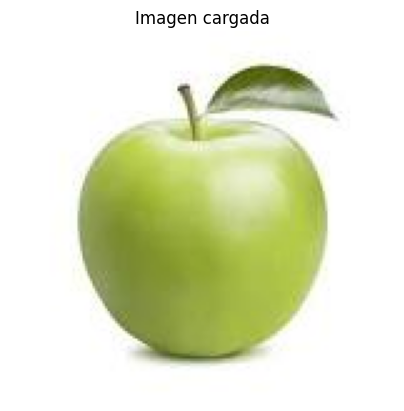

🔍 La imagen fue clasificada como: *Manzana*


In [3]:
#INGRESO IMAGEN

# Probar para ver la imagen y clasificarla

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# --- 1) Ruta de la imagen ---
img_path = "/kaggle/input/manzanaverdecuatro/manzanaVerde.jpg"

# --- 2) Cargar imagen ---
imagen = Image.open(img_path).convert("RGB")

# --- 3) Mostrar imagen ---
plt.imshow(imagen)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# --- 4) Preparar transformaciones (igual que test_transform) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 5) Transformar imagen ---
tensor_img = transform(imagen).unsqueeze(0).to(DEVICE)  # CORREGIDO: usar DEVICE

# --- 6) Predecir ---
model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred_idx = torch.argmax(output, dim=1).item()

# --- 7) Obtener clase predicha ---
pred_class = train_dataset.classes[pred_idx]
print(f"🔍 La imagen fue clasificada como: *{pred_class}*")



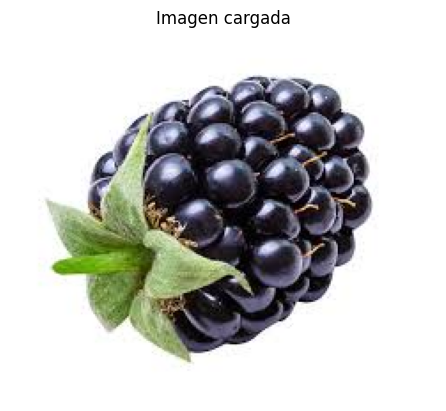

🔍 La imagen fue clasificada como: *Mora*


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# --- 1) Ruta de la imagen ---
img_path = "/kaggle/input/moracuatro/mora.jpg"

# --- 2) Cargar imagen ---
imagen = Image.open(img_path).convert("RGB")

# --- 3) Mostrar imagen ---
plt.imshow(imagen)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# --- 4) Preparar transformaciones (igual que test_transform) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 5) Transformar imagen ---
tensor_img = transform(imagen).unsqueeze(0).to(DEVICE)  # CORREGIDO: usar DEVICE

# --- 6) Predecir ---
model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred_idx = torch.argmax(output, dim=1).item()

# --- 7) Obtener clase predicha ---
pred_class = train_dataset.classes[pred_idx]
print(f"🔍 La imagen fue clasificada como: *{pred_class}*")

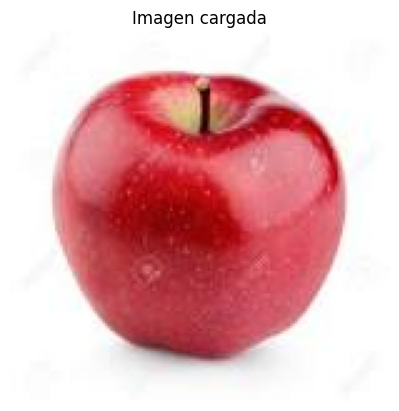

🔍 La imagen fue clasificada como: *Manzana*


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# --- 1) Ruta de la imagen ---
img_path = "/kaggle/input/manzanacuatro/manzana.jpg"

# --- 2) Cargar imagen ---
imagen = Image.open(img_path).convert("RGB")

# --- 3) Mostrar imagen ---
plt.imshow(imagen)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# --- 4) Preparar transformaciones (igual que test_transform) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 5) Transformar imagen ---
tensor_img = transform(imagen).unsqueeze(0).to(DEVICE)  # CORREGIDO: usar DEVICE

# --- 6) Predecir ---
model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred_idx = torch.argmax(output, dim=1).item()

# --- 7) Obtener clase predicha ---
pred_class = train_dataset.classes[pred_idx]
print(f"🔍 La imagen fue clasificada como: *{pred_class}*")

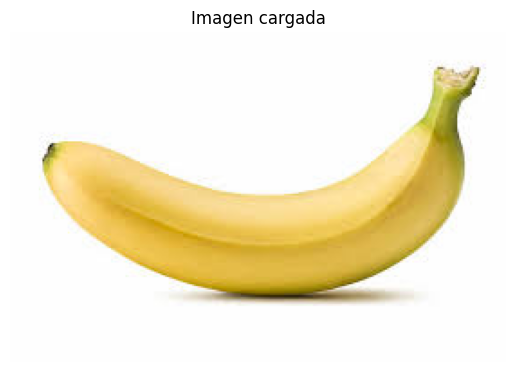

🔍 La imagen fue clasificada como: *Banana*


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# --- 1) Ruta de la imagen ---
img_path = "/kaggle/input/bananacuatro/banana.jpg"

# --- 2) Cargar imagen ---
imagen = Image.open(img_path).convert("RGB")

# --- 3) Mostrar imagen ---
plt.imshow(imagen)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# --- 4) Preparar transformaciones (igual que test_transform) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 5) Transformar imagen ---
tensor_img = transform(imagen).unsqueeze(0).to(DEVICE)  # CORREGIDO: usar DEVICE

# --- 6) Predecir ---
model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred_idx = torch.argmax(output, dim=1).item()

# --- 7) Obtener clase predicha ---
pred_class = train_dataset.classes[pred_idx]
print(f"🔍 La imagen fue clasificada como: *{pred_class}*")

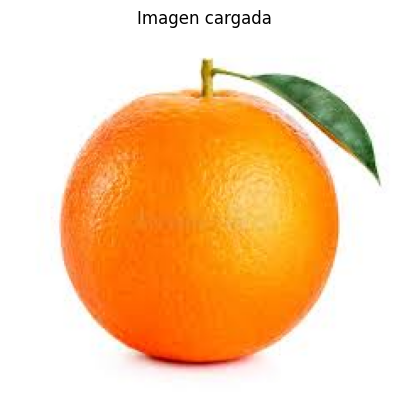

🔍 La imagen fue clasificada como: *Naranja*


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# --- 1) Ruta de la imagen ---
img_path = "/kaggle/input/naranjacuatro/naranja.jpg"

# --- 2) Cargar imagen ---
imagen = Image.open(img_path).convert("RGB")

# --- 3) Mostrar imagen ---
plt.imshow(imagen)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# --- 4) Preparar transformaciones (igual que test_transform) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 5) Transformar imagen ---
tensor_img = transform(imagen).unsqueeze(0).to(DEVICE)  # CORREGIDO: usar DEVICE

# --- 6) Predecir ---
model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred_idx = torch.argmax(output, dim=1).item()

# --- 7) Obtener clase predicha ---
pred_class = train_dataset.classes[pred_idx]
print(f"🔍 La imagen fue clasificada como: *{pred_class}*")